# Preprocessing Concepts

### Below is a sample where we just print the center, left, right camera views, all data pre-processing will be made to work here before we train the network

In [2]:
import csv, cv2
import matplotlib.pyplot as plt
import numpy as np

STEER_CORRECTION = .25

data = []
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        data.append(line)

images = []
steering_angles = []
for i in range(1):
    data_point = data[i]
    name = './data/IMG/'+ data_point[0].split('\\')[-1]
    left = './data/IMG/'+ data_point[1].split('\\')[-1]
    righ = './data/IMG/'+ data_point[2].split('\\')[-1]
    
    center_image = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)
    left_image  = cv2.cvtColor(cv2.imread(left), cv2.COLOR_BGR2RGB)
    right_image = cv2.cvtColor(cv2.imread(righ), cv2.COLOR_BGR2RGB)
    center_angle = float(data_point[3])
    left_angle = float(data_point[3]) + STEER_CORRECTION
    righ_angle = float(data_point[3]) - STEER_CORRECTION
    images.extend( (center_image,left_image, right_image ) )
    steering_angles.extend( (center_angle, left_angle, righ_angle) )

plt.figure(figsize=(20, 25))
for i in range(3):
    plt.subplot(1, 3, i + 1)    
    title = "A picture: {0}\nSteering angle: {1:.3f}".format(i, steering_angles[i])
    plt.title(title, wrap=True)
    plt.imshow(images[i])

## Flipped images

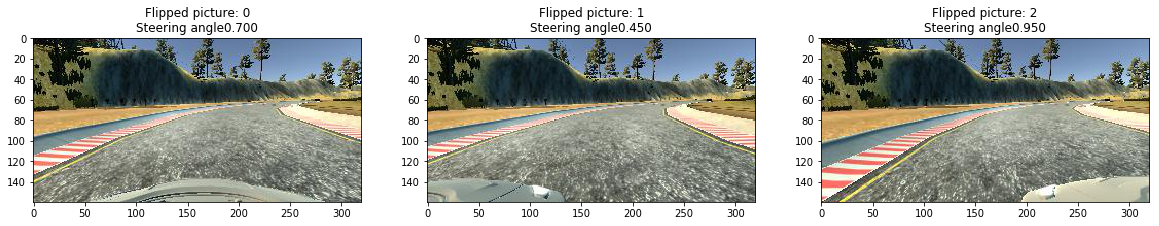

In [33]:
flipped_images = []
new_angles = []

for i in range(3):
    data_point = data[i]
    flipped = np.copy(np.fliplr(images[i]))   
    flipped_images.append(flipped)
    new_angles.append(-1*steering_angles[i])
    
plt.figure(figsize=(20, 25))
for i in range(3):
    plt.subplot(1, 3, i + 1)    
    title = "Flipped picture: {0}\nSteering angle{1:.3f}".format(i, new_angles[i])
    plt.title(title, wrap=True)
    plt.imshow(flipped_images[i])

## Change brightness

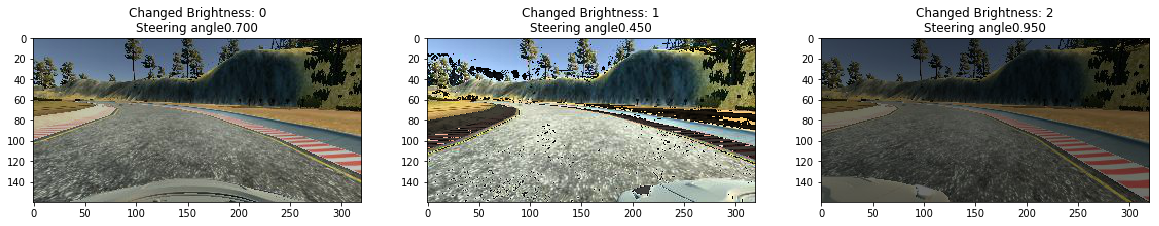

In [38]:
def change_brightness(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    # uniform means all outcomes equally likely, 
    # defaults to [0,1)
    random_bright = .25 + np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

brightness_changed = []
# use angles

for i in range(3):    
    bright_diff = change_brightness(images[i])   
    brightness_changed.append(bright_diff)
    
plt.figure(figsize=(20, 25))
for i in range(3):
    plt.subplot(1, 3, i + 1)    
    title = "Changed Brightness: {0}\nSteering angle{1:.3f}".format(i, new_angles[i])
    plt.title(title, wrap=True)
    plt.imshow(brightness_changed[i])


## Crop
(found that if we take 50px off the top and 80 off the bottom the image is  totally road)

(160, 320, 3) 80


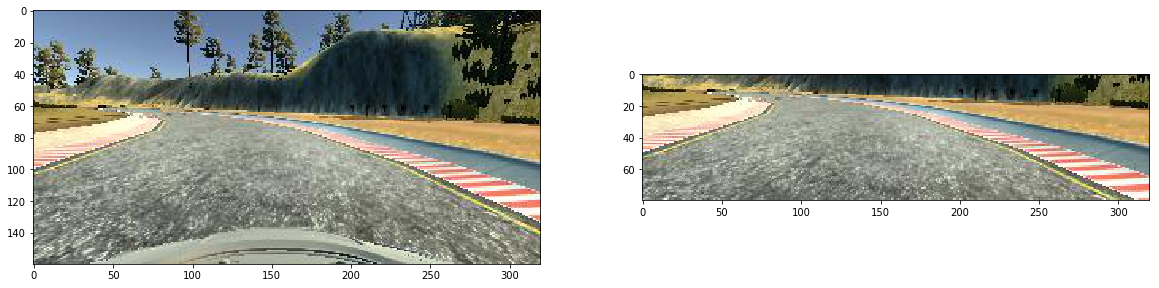

In [36]:
import cv2

def cropImage(img):       
    
    # top to cut off, bottom to cut off
    x,w = 0,img.shape[1]
    
    #left to cut off, right to cut off
    y,h = 50, (img.shape[0] - 80)
    crop_img = np.copy(img[y:y+h, x:x+w])
    return crop_img

img = images[0]
print(img.shape, img.shape[0] - 80)

crop_img = cropImage(img)

def printTwoImages(img, changed_img):
    plt.figure(figsize=(20, 25))
    
    for i,v in enumerate([img,changed_img]): 
        plt.subplot(1, 2, i+1) 
        plt.imshow(v)
        '''
        plt.subplot(1, 2, 2) 
        plt.imshow(changed_img)
        '''
printTwoImages(img, crop_img)

## Normalize
won't print because all RGB values would be -1,0 or 1 and we'd need a ceil function, etc.

In [32]:
def normalize(img):
    # given in a tutorial or something
    return img/255.5 - .5
an_image = images[0]
an_image = normalize(an_image)

print(images[0])
print(an_image)

[[[116 145 185]
  [116 145 185]
  [115 144 184]
  ...
  [ 26  28  14]
  [ 63  65  51]
  [  1   3   0]]

 [[116 145 185]
  [116 145 185]
  [116 145 185]
  ...
  [ 20  22   9]
  [ 22  24  11]
  [ 22  24  11]]

 [[117 146 186]
  [117 146 186]
  [117 146 186]
  ...
  [  7   7   0]
  [ 25  25  15]
  [ 17  17   7]]

 ...

 [[160 165 161]
  [123 128 124]
  [ 87  92  88]
  ...
  [141 142 126]
  [172 173 157]
  [172 173 157]]

 [[ 96 100  99]
  [ 66  70  69]
  [ 78  82  81]
  ...
  [115 116 100]
  [153 154 138]
  [175 176 160]]

 [[119 123 122]
  [124 128 127]
  [ 93  97  96]
  ...
  [149 150 134]
  [148 149 133]
  [138 139 123]]]
[[[-0.04598826  0.06751468  0.22407045]
  [-0.04598826  0.06751468  0.22407045]
  [-0.04990215  0.06360078  0.22015656]
  ...
  [-0.39823875 -0.39041096 -0.44520548]
  [-0.25342466 -0.24559687 -0.30039139]
  [-0.49608611 -0.48825832 -0.5       ]]

 [[-0.04598826  0.06751468  0.22407045]
  [-0.04598826  0.06751468  0.22407045]
  [-0.04598826  0.06751468  0.22407045]
  

## Resize
to 200 x 166 per the NVIDIA model

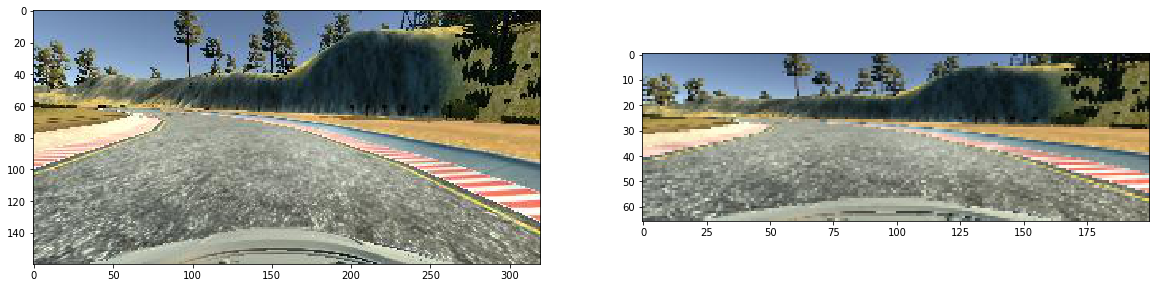

In [39]:
def resize(image):
    return np.copy(cv2.resize(image, (200,66) ) )

printTwoImages(img, resize(img))

## Flatten Steering Angle Distribution
(we want to get a before and after)

In [41]:
print(len(data))

53


In [ ]:
image_data = []
steering_angle_data = []
for i in range(1):
    data_point = data[i]
    name = './data/IMG/'+ data_point[0].split('\\')[-1]
    left = './data/IMG/'+ data_point[1].split('\\')[-1]
    righ = './data/IMG/'+ data_point[2].split('\\')[-1]
    
    center_image = cv2.cvtColor(cv2.imread(name), cv2.COLOR_BGR2RGB)
    left_image  = cv2.cvtColor(cv2.imread(left), cv2.COLOR_BGR2RGB)
    right_image = cv2.cvtColor(cv2.imread(righ), cv2.COLOR_BGR2RGB)
    center_angle = float(data_point[3])
    left_angle = float(data_point[3]) + STEER_CORRECTION
    righ_angle = float(data_point[3]) - STEER_CORRECTION
    images.extend( (center_image,left_image, right_image ) )
    steering_angles.extend( (center_angle, left_angle, righ_angle) )